In [1]:
import pandas as pd
import numpy as np
import scipy
import networkx as nx
import pylab
from pathlib import Path
from scipy.stats import bernoulli
import random
import math
import statistics
import matplotlib.pyplot as plt
import matplotlib
try:
    import _pickle as pickle
except:
    import pickle
import csv
pylab.rcParams['figure.dpi'] = 600
import os
import time
plt.rcParams["font.family"] = "Arial"

In [2]:
def list_diff(list1, list2):
    'an important function help to find item in list1 that is not in list2'
    'list1 should be larger than'
    out1 = [item for item in list1 if not item in list2]
    out2 = [item for item in list2 if not item in list1]
    out = out1 + out2
    return out

In [3]:
def list_same(list1, list2):
    'an important function help to find item in list1 that is not in list2'
    out = [item for item in list1 if item in list2]
    return out

In [4]:
def CreateCirculantNursingNetwork1(s,d,p,r, showgraph=False, savegraph=False, **kwargs):
    """
    Great a circulent neighbouring graph
        s -- Number of staff.
        d -- degrees, density of internal graph
        p -- outside infectious probability(unconditional)
        r -- daily probability of infection from internal contact in group 
        showgraph -- Displays graph, if True.
        savegraph -- Saves graph, if True. Pass filename as keyword ("filename") argument.

        Returns a networkx graph with s+1 nodes where the extra node is a supernode to model infection from the outside world.
        Note that the Supernode is connected with all the nodes in the graph
    """
    m = int(d/2)
    V = [i for i in range(1,m+1)]
    G = nx.generators.classic.circulant_graph(s, V)
    nodes = np.array(G.nodes)
    G = nx.relabel_nodes(G, mapping=dict(zip(nodes, nodes+1)), copy=False)
    nx.set_edge_attributes(G, r, 'capacity')
    G.add_node(0)
    G.add_edges_from([(0, i) for i in range(1,s+1)],capacity=p)
    if showgraph:
        nx.draw_networkx(G)
        pylab.show()
    if savegraph:
        pylab.clf()
        nx.draw_networkx(G)
        data_folder = Path(r"/Documents/Covid-19/latency")
        filename = kwargs.get('filename', "nursing_network_s{0}.png".format(s))
        pylab.savefig(filename)
    return G

In [5]:
def CreateCirculantNursingNetwork2(s,d,p,r, showgraph=False, savegraph=False, **kwargs):
    """
    Great a circulent zooming graph
        s -- Number of staff.
        d -- degrees, density of internal graph
        p -- outside infectious probability(unconditional)
        r -- daily probability of infection from internal contact in group 
        showgraph -- Displays graph, if True.
        savegraph -- Saves graph, if True. Pass filename as keyword ("filename") argument.

        Returns a networkx graph with s+1 nodes where the extra node is a supernode to model infection from the outside world.
        Note that the Supernode is connected with all the nodes in the graph
    """
    m = int(d/2)
    V = [i for i in range(int(s/2)-m+1,int(s/2))]
    V.append(1)
    G = nx.generators.classic.circulant_graph(s, V)
    nodes = np.array(G.nodes)
    G = nx.relabel_nodes(G, mapping=dict(zip(nodes, nodes+1)), copy=False)
    nx.set_edge_attributes(G, r, 'capacity')
    G.add_node(0)
    G.add_edges_from([(0, i) for i in range(1,s+1)],capacity=p)
    if showgraph:
        nx.draw_networkx(G)
        pylab.show()
    if savegraph:
        pylab.clf()
        nx.draw_networkx(G)
        data_folder = Path(r"/Documents/Covid-19/latency")
        filename = kwargs.get('filename', "nursing_network_s{0}.png".format(s))
        pylab.savefig(filename)
    return G

In [6]:
def CreateDrandomNursingNetwork(s,d,p,r, showgraph=False, savegraph=False, **kwargs):
    """
    Great a circulent neighbouring graph
        s -- Number of staff.
        d -- degrees, density of internal graph
        p -- outside infectious probability(unconditional)
        r -- daily probability of infection from internal contact in group 
        showgraph -- Displays graph, if True.
        savegraph -- Saves graph, if True. Pass filename as keyword ("filename") argument.

        Returns a networkx graph with s+1 nodes where the extra node is a supernode to model infection from the outside world.
        Note that the Supernode is connected with all the nodes in the graph
    """
    G=nx.random_regular_graph(d, s)
    nodes = np.array(G.nodes)
    G = nx.relabel_nodes(G, mapping=dict(zip(nodes, nodes+1)), copy=False)
    nx.set_edge_attributes(G, r, 'capacity')
    G.add_node(0)
    G.add_edges_from([(0, i) for i in range(1,s+1)],capacity=p)
    if showgraph:
        nx.draw_networkx(G)
        pylab.show()
    if savegraph:
        pylab.clf()
        nx.draw_networkx(G)
        data_folder = Path(r"/Documents/Covid-19/latency")
        filename = kwargs.get('filename', "nursing_network_s{0}.png".format(s))
        pylab.savefig(filename)
    return G

In [7]:
def Generate_Nursing_Network(gtyp, s, d,p,r ):

    if gtyp=='complete':
        G = CreateCirculantNursingNetwork1(s,s-1,p,r,showgraph=False, savegraph=False)
    if gtyp=='circulant_neighbouring':
        G = CreateCirculantNursingNetwork1(s,d,p,r,showgraph=False, savegraph=False)
    if gtyp=='circulant_crossing': 
        G = CreateCirculantNursingNetwork2(s,d,p,r,showgraph=False, savegraph=False)
    if gtyp=='random_d':
        G=CreateDrandomNursingNetwork(s,d,p,r, showgraph=False, savegraph=False)

    return G

In [8]:
def Simulation(J, I, s, G, p, r, l, t_0, T):
    """
    This function is used to simulate the infectious routes in the given network G
    Great a circulent zooming graph
        s -- Number of staff
        G -- Overall Network graph
        J -- Number of bataches of simulations (batches are used in calculating CI)
        I -- Number of simulations in each batches
        p -- outside infectious probability(unconditional)
        r -- daily probability of infection from internal contact in group 
        l -- latency days
        t_0 -- Outbreak tolerance (in days)
        Note that all the array is converted to a list, becasue it is benifit in adding and removing tuples in list
    """
    
    #generate the conditional probability list; quote from Sudesh'codes
    q=1-p
    factor = 1/(1-q**s)
    p_0=[factor * p**k * q**(s-k) * scipy.special.comb(s, k, exact=False, repetition=False) for k in range(1, s+1)]
    #print(sum(p_0))
    #print('truncted binomial',p_0)
    #Sum=sum(i for i in p_0)
    #print(Sum)
    #finished
    #initialize memory sets, save in dictionary,time index t is the keys of those dictionaries
    #note that we need to trak days been infected in set Infectied_No_Contagious
    #there are two time index (t,m) as the key in Infectied_No_Contagious
    NIS={}
    INC={}
    IYC={}
    CIS={}
    UI={}
    #initialize label set
    S=[temp for temp in range(1,s+1)]
    #Start simulation
    for j in range(1,J+1):
        for i in range(1,I+1):
            #print('Reps = {}'.format(i))
            New_Infection={}
            Infected_No_Contagious={}
            Infected_Yes_Contagious={}
            Cumulated_Infection={}
            Uninfected={}
            for t in range(t_0+1):
                #print('--------------------------------------------------------------------------------')
                #print('Time',t)

                #--------------------------------------------------------------------------------------
                if t==0: #initialize number of infections at the begining of day 1
                    #Initialize infection routes
                    #generate initial number of infectio
                    initial_number=np.random.choice(S, p=p_0)
                    #check and print
                    #print('Number of initial infectious:',initial_number)
                    #generate specific staff been infected;note that the output is an array and should be converted into list
                    initial_infection_labels=np.random.choice([i for i in range(1,s+1)], initial_number)
                    #Update other sets
                    New_Infection[t]=initial_infection_labels.tolist()
                    Cumulated_Infection[t]=initial_infection_labels.tolist()
                    Cumulated_Infection[t].append(0)
                    Infected_Yes_Contagious[t]=initial_infection_labels.tolist()
                    Uninfected[t]=list_diff(S,New_Infection[t]) 
                    #print('Infectious nodes at the end of day t={0}: {1}'.format(t,Infected_Yes_Contagious[t]))

                #go to step3 in the pseudocode
                #--------------------------------------------------------------------------------------
                if t >= 1:

                    #print(Infected_No_Contagious)
                    #Update Infected_No_Contagious,Infected_Yes_Contagious after a day is finished
                    Cumulated_Infection[t]=Cumulated_Infection[t-1].copy()
                    Infected_Yes_Contagious[t]=Infected_Yes_Contagious[t-1].copy()
                    Uninfected[t]=Uninfected[t-1].copy()
                    #Update the external infectious
                    if t>=2:
                        for n in Uninfected[t]:
                            ran_external = bernoulli.rvs(p)
                            if ran_external == 1:
                                Infected_Yes_Contagious[t].append(n)
                                Cumulated_Infection[t].append(n)
                                Uninfected[t].remove(n)
                        #infected_to_infectious=[]
                    for m in range(2,l+1):#iterate from m=[1,...,latency]
                        if (t-1,m-1) in Infected_No_Contagious.keys():
                            Infected_No_Contagious[(t,m)]=Infected_No_Contagious[(t-1,m-1)].copy()
                            for n in Infected_No_Contagious[(t,m)]:
                                if bernoulli.rvs(p)==1:
                                    Infected_No_Contagious[(t,m)].remove(n)
                                    Infected_Yes_Contagious[t].append(n)
                                    #print('node {} becomes external infectious at day{}'.format(n,t))
                    if (t-1,l) in Infected_No_Contagious.keys():#this part is tricky, need more explainations in report
                        #print(Infected_Yes_Contagious[t])
                        Infected_Yes_Contagious[t]=Infected_Yes_Contagious[t]+Infected_No_Contagious[(t-1,l)]
                    #print('Infected but not infectious nodes:')\
                    #xx=Cumulated_Infection[t].copy()
                    #xx.remove(0)
                    #print('Cumulative infected nodes at the beginning of the day:',xx)
                #--------------------------------------------------------------------------------------
                    #Update Uninfected,New_Infection,Cumulated_Infection
                    #Generate New Infection from outside source


                    New_Infection[t]=[]
                    for n in Uninfected[t]:
                        #print(n)
                        neighbours=list(G._adj[n])
                        #print(neighbours)
                        neighbours.remove(0)
                        P_infected=1-(1-r)**len(list_same(neighbours, Infected_Yes_Contagious[t]))
                        ran_data=bernoulli.rvs(P_infected)#ran_data=bernoulli.rvs(G[0][n]['capacity'])
                        if ran_data==1:
                            New_Infection[t].append(n)
                            Cumulated_Infection[t].append(n)
                            Uninfected[t].remove(n)

                    #print()
                    #print('Nodes newly infected internally:',New_Infection[t])
                    #--------------------------------------------------------------------------------------
                    #Update Infected_No_Contagious(just been infected)
                    Infected_No_Contagious[(t,1)]=New_Infection[t].copy()
        #---------------------------------------------------------------------------------------------
        #package data
            IYC[(j,i)]=Infected_Yes_Contagious  
            NIS[(j,i)]=New_Infection
            INC[(j,i)]=Infected_No_Contagious
            CIS[(j,i)]=Cumulated_Infection
            UI[(j,i)]=Uninfected
        #print(Infected_No_Contagious)
    return (IYC,INC,NIS,CIS,UI)

In [11]:
def Point_Estimate(J,I,s,l,t_0,OUT,fn):
    """
    s -- Number of staff
    IYC - a dictionary meaning Infected_Yes_Contagious (OUT[3])
    pay attention to the time index of IYC should use t-1 usually: at the beginning of day t
    t_0 -- Outbreak tolerance (in days)
    fn - false negative rate
    """
    IYC=OUT[0]
    CIS=OUT[3]
    TO={}#index(k,j,i)
    INFECT={}#index(k,j,i)
    k_max=s//2
    #-----------------------------------------------------------------------------------------
    for j in range(1,J+1):
        for i in range(1,I+1):
            
            S=[label for label in range(1,s+1)]
            #random.shuffle(S)#reorder
            #S=[25, 80, 26, 4, 61, 23, 48, 14, 32, 31, 64, 9, 59, 47, 27, 2, 99, 30, 22, 69, 24, 81, 10, 53, 50, 83, 100, 44, 71, 19, 13, 43, 94, 49, 74, 84, 7, 57, 5, 18, 11, 8, 58, 90, 67, 56, 66, 21, 33, 82, 86, 15, 60, 95, 98, 63, 41, 1, 62, 40, 3, 6, 36, 37, 28, 89, 73, 76, 96, 35, 38, 17, 12, 46, 92, 72, 78, 70, 93, 51, 52, 87, 88, 39, 77, 68, 16, 29, 55, 45, 42, 54, 91, 97, 79, 65, 20, 34, 75, 85]
            Q=S.copy()
            for queue in range(t_0//2):
                Q=Q+S
            for k in range(1,k_max+1):
                TO[(k,j,i)]=0
                for t in range(1,t_0+1):
                    if TO[(k,j,i)]==1:
                        break
                    test_list=[Q[m] for m in range(k*(t-1),k*t)]
                    #print('testlist',test_list)
                    #print('infectedlist',IYC[(j,i)][t])
                    out=list_same(test_list,IYC[(j,i)][t])
                    if out:#if there are someone dected been tested at the begining day t+1
                        for item in out:
                            ran_data=bernoulli.rvs(fn)
                            if ran_data==0:
                                TO[(k,j,i)]=1
                                INFECT[k]=INFECT.get(k,[(len(CIS[j,i][t])-1)])
                                INFECT[k].append((len(CIS[j,i][t])-1))
                                #print(k,t)
                                break
                                
    #print(INFECT)
    return (TO,INFECT)
            

In [28]:
def Save_File(J, I, s, p, r, fn, l, t_0, OUT):
    '''
    graph_type: 1-'complete';2-'circulant_neighbouring';3-'circulant_crossing';4-'random_d'
    '''
    start=time.time()
    print('Batch{0}_Reps{1}_Staff{2}_Degrees{3}_p_outside{4}_runningtime_{5}'.format(J,I,s,d,p,time.time()-start))
    
    gtyp='complete'
    
    k_max=s//2
    #------------------------------------------------------------------------------------------------ 
    #simulation
    PUT=Point_Estimate(J,I,s,l,t_0,OUT,fn)
    TO=PUT[0]
    INFECT=PUT[1]
    for j in range(1,J+1):
    #------------------------------------------------------------------------------------------------
        #get number of infectious
        save_file=[]
        infectious1=[statistics.mean(len(OUT[3][j,i][t])/s  for i in range(1,I+1)) for t in range(1,t_0+1)]
        infectious1SD=[statistics.stdev([len(OUT[3][j,i][t])/s  for i in range(1,I+1)]) for t in range(1,t_0+1)]
        infectious2=[statistics.mean(INFECT[k])/s for k in range(1,k_max+1)]
        infectious2SD=[statistics.stdev(INFECT[k])/s for k in range(1,k_max+1)]
            
        #print(TO)
    #------------------------------------------------------------------------------------------------  
    #get CI
        Pa={}
        SD={}
        for k in range(1,k_max+1):
            Pa[k]=sum(TO[k,j,i] for i in range(1,I+1))/I
            SD[k]=math.sqrt(Pa[k]*(1-Pa[k])/I)
        L1 = sorted(Pa.items()) # sorted by key, return a list of tuples
        x, y = zip(*L1) # unpack a list of pairs into two tuples
        L2=[Pa[k]-1.96*v for (k,v) in SD.items()]
        L3=[Pa[k]+1.96*v for (k,v) in SD.items()]
        column_name=['number of batches','simulation in each batch','number of staff','degrees','p','r','fn','latency','graph teype','k','Prob_detected','SD','CI lower','CI upper','portion_infected','portion_LB','portion_UB']    
        for k in range(1,k_max+1):
            tempk=[j,I,s,d,p,r,fn,l,gtyp,k,Pa[k],SD[k],L2[k-1],L3[k-1],infectious2[k-1],infectious2[k-1]-1.96*infectious2SD[k-1]/math.sqrt(len(INFECT[k])),infectious2[k-1]+1.96*infectious2SD[k-1]/math.sqrt(len(INFECT[k]))]
            save_file.append(tempk)
        fig,ax=plt.subplots()
        plt.plot(x, y,label='point_estimate')
        plt.plot(x, L2,'b--')
        plt.plot(x, L3,'b--')
        #plt.plot(x, infectious2,'green',label='infected staff')
        #plt.plot(x, [infectious2[k]-1.96*infectious2SD[k]/math.sqrt(len(INFECT[k+1])) for k in range(k_max)],'g--')
        #plt.plot(x, [infectious2[k]+1.96*infectious2SD[k]/math.sqrt(len(INFECT[k+1])) for k in range(k_max)],'g--')
        plt.legend(loc='center right', frameon=False)
        plt.title("batch={0}_reps={1}_s={2}_l={3}_t={4}_p={5}\nr={6}_fn={7}_{8}_degree={9}".format(j,I, s,l, t_0, p, r, fn,gtyp,d))
        #vals = [0,0.2,0.4,0.6,0.8,1.0]
        #ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
        ax.grid(linestyle=':')
        plt.show()
    #------------------------------------------------------------------------------------------------  
    #save to excel
        d1 = pd.DataFrame(save_file)
        d1.columns = column_name
        #print(d1)
        d1.to_excel(writer, sheet_name='{0}_{1}_{2}_{3}_{4}_{5}_{6}'.format(j,I,s,d,p,l,t_0))
        D[(j,I,s,d,p,l,t_0)]=d1
    return 
    

Batch30_Reps50000_Staff100_Degrees100_p_outside0.0001_runningtime_5.9604644775390625e-06


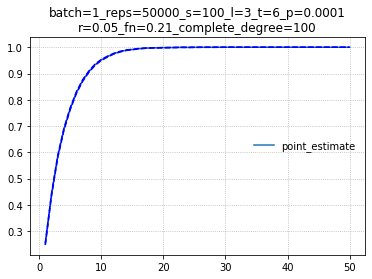

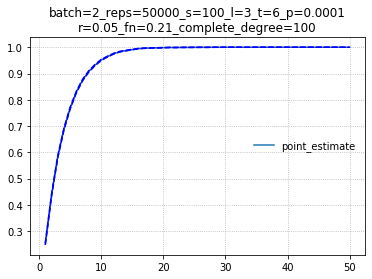

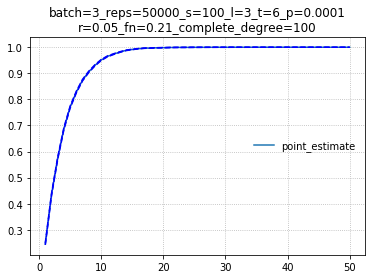

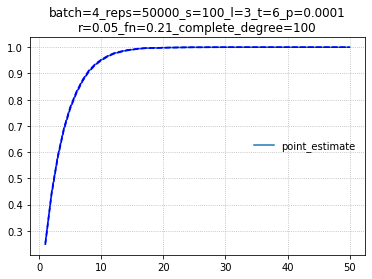

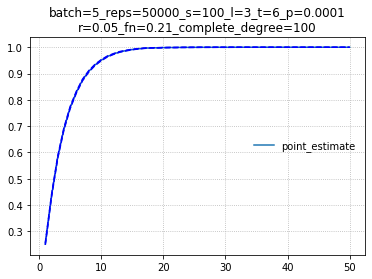

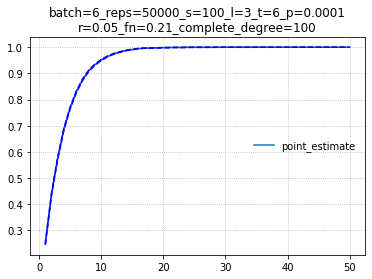

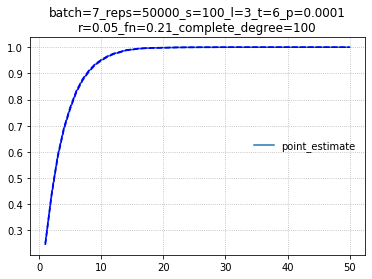

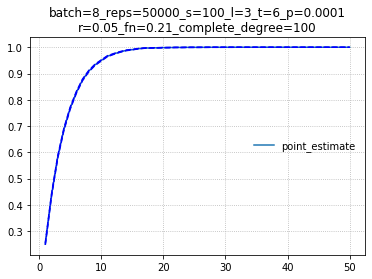

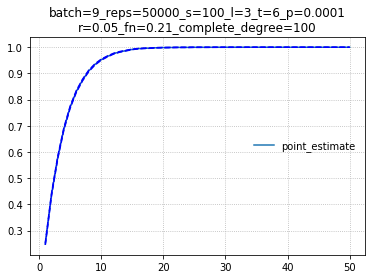

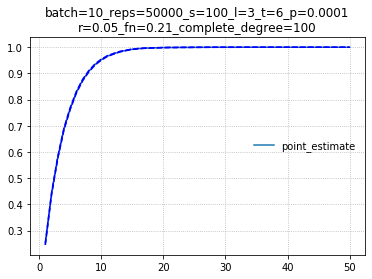

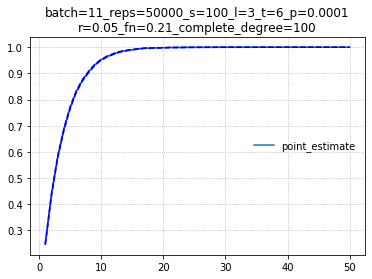

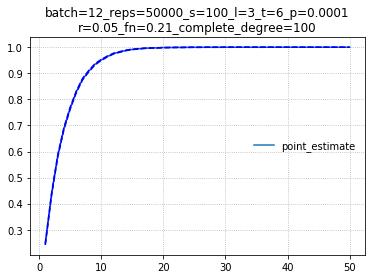

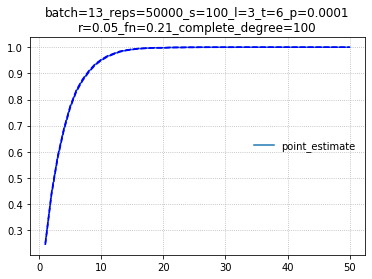

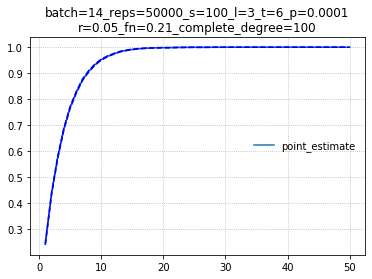

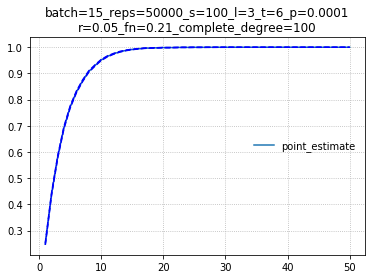

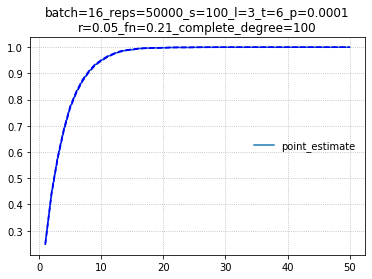

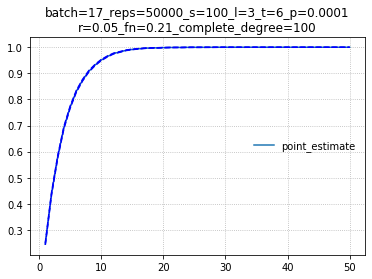

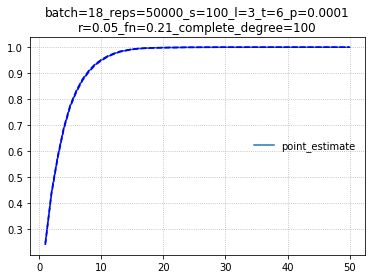

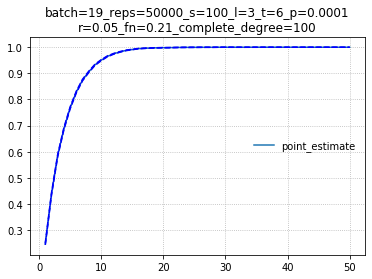

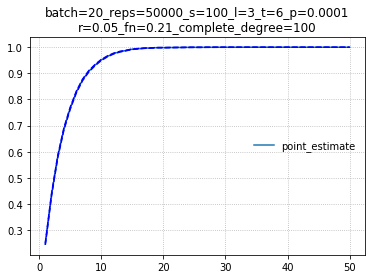

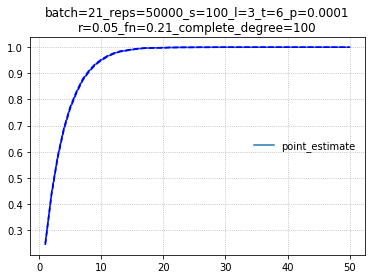

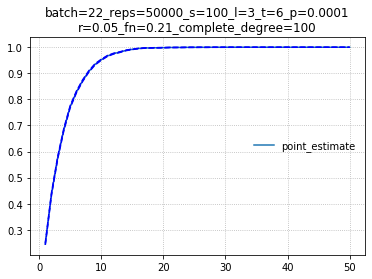

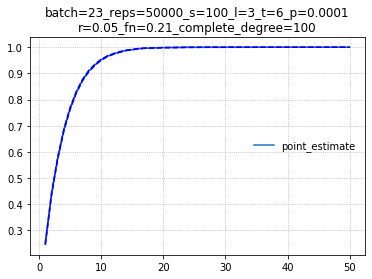

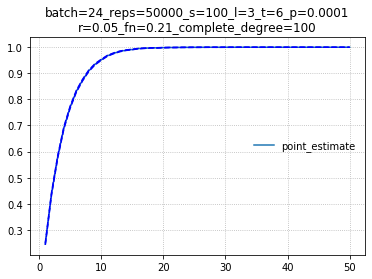

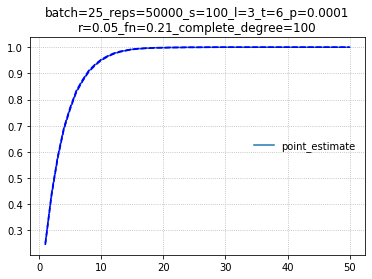

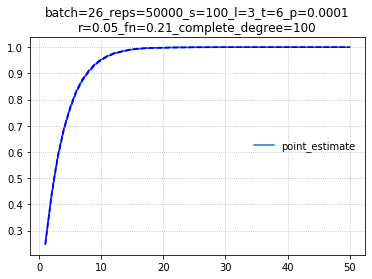

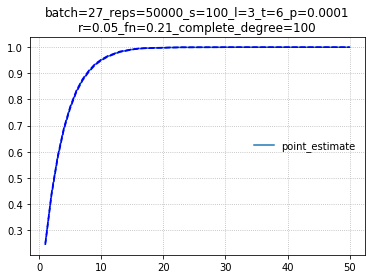

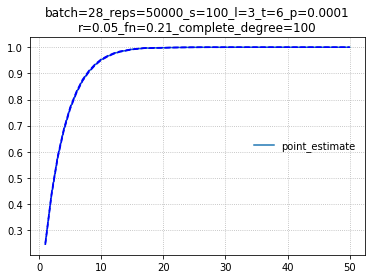

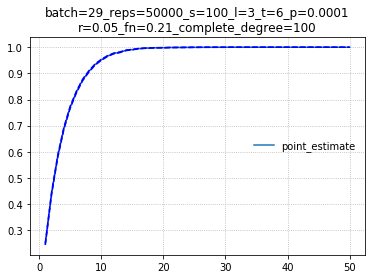

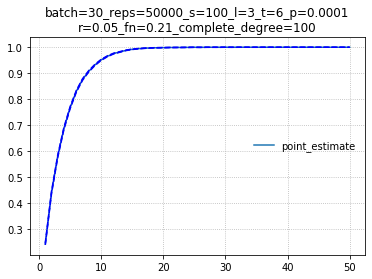

running time 10481.920392990112


In [29]:
if __name__ == '__main__':
    D={}
    O={}
    writer = pd.ExcelWriter('SImulationcheck1208.xlsx', engine = 'xlsxwriter')
    writer1=pd.ExcelWriter('',engine = 'xlsxwriter')
    T=0.1
    fn=0.21
    r=0.05
    for s in [100]:
        for p in [0.0001]:
            for d in [100]:# d must be int format
                for t_0 in [6]:
                    for l in [3]:  
                        for J in [30]:
                            for I in [50000]:
                                start=time.time()
                                G=Generate_Nursing_Network('circulant_neighbouring', s, d,p,r )
                                #OUT=Simulation(J,I, s, G, p, r, l, t_0, T)
                                #O[(J,I,s,p,r,l,t_0)]=OUT
                                #pickle.dump(O, open('Simulationpath1206.p','wb'))
                                Save_File(J, I, s, p, r, fn, l, t_0, OUT)
                                pickle.dump(D, open('Simulationcheck1208.p','wb'))
                                
                                print('running time',time.time()-start)
    writer.save()

In [30]:
D

{(1,
  50000,
  100,
  100,
  0.0001,
  3,
  6):     number of batches  simulation in each batch  number of staff  degrees  \
 0                   1                     50000              100      100   
 1                   1                     50000              100      100   
 2                   1                     50000              100      100   
 3                   1                     50000              100      100   
 4                   1                     50000              100      100   
 5                   1                     50000              100      100   
 6                   1                     50000              100      100   
 7                   1                     50000              100      100   
 8                   1                     50000              100      100   
 9                   1                     50000              100      100   
 10                  1                     50000              100      100   
 11             

Batch1_Reps100000_Staff100_Degrees100_p_outside0.0001_runningtime_1.3828277587890625e-05


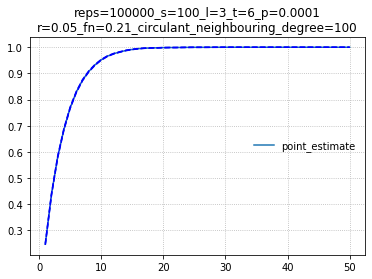

running time 6867.967617034912
Batch1_Reps100000_Staff100_Degrees100_p_outside0.01_runningtime_9.5367431640625e-07


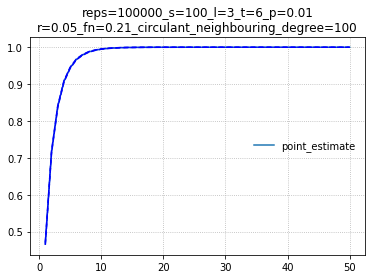

running time 6854.7392411231995


In [31]:
d=100
writer = pd.ExcelWriter('SImulationcheck1201.xlsx', engine = 'xlsxwriter')
D={}
for p in [0.0001,0.01]:
    start=time.time()
                                
    D[(1, 100000, 100, p, 0.05, 0.21, 3, 6, d)]=Save_File(1, 100000, 100, p, 0.05, 0.21, 3, 6, 0)
    #pickle.dump(D, open('Simulationcheck1129.p','wb'))

    print('running time',time.time()-start)

In [34]:
writer = pd.ExcelWriter('SImulationcheck1201.xlsx', engine = 'xlsxwriter')
for key,value in D.items():
    (J, I, s, p, r, fn, l, t_0, T)=key
    value.to_excel(writer, sheet_name='{0}_{1}_{2}_{3}_{4}_{5}_{6}'.format(J,I,s,d,p,l,t_0))
writer.save()

In [33]:
writer.save()

In [12]:
#check for complete graph:
G=Generate_Nursing_Network('circulant_neighbouring', 100, 100,0.0001,0.05 )
G.edges()
list(G._adj[1])

[100,
 99,
 98,
 97,
 96,
 95,
 94,
 93,
 92,
 91,
 90,
 89,
 88,
 87,
 86,
 85,
 84,
 83,
 82,
 81,
 80,
 79,
 78,
 77,
 76,
 75,
 74,
 73,
 72,
 71,
 70,
 69,
 68,
 67,
 66,
 65,
 64,
 63,
 62,
 61,
 60,
 59,
 58,
 57,
 56,
 55,
 54,
 53,
 52,
 51,
 50,
 49,
 48,
 47,
 46,
 45,
 44,
 43,
 42,
 41,
 40,
 39,
 38,
 37,
 36,
 35,
 34,
 33,
 32,
 31,
 30,
 29,
 28,
 27,
 26,
 25,
 24,
 23,
 22,
 21,
 20,
 19,
 18,
 17,
 16,
 15,
 14,
 13,
 12,
 11,
 10,
 9,
 8,
 7,
 6,
 5,
 4,
 3,
 2,
 0]

In [148]:
writer.save()

In [105]:
data2=pd.ExcelFile('OUTPUT0622test.xlsx')
D2={}
for s in [100]:
    for p in [0.01]:
        for l in [3]:  
            for J in [1]:
                for I in [50000]:
                    for t_0 in [15]:
                        D2[(J, I, s, p, r, fn, l, t_0, T)]=pd.read_excel(data2,'{0}_{1}_{2}_{3}_{4}_{5}_{6}'.format(J,I,s,60,p,l,t_0))

In [117]:
data1=pd.ExcelFile('OUTPUT0622test.xlsx')
D1={}
for s in [100]:
    for p in [0.01]:
        for l in [3]:  
            for J in [1]:
                for I in [50000]:
                    for t_0 in [15]:
                        D1[(J, I, s, p, r, fn, l, t_0, T)]=pd.read_excel(data1,'{0}_{1}_{2}_{3}_{4}_{5}_{6}'.format(J,I,s,100,p,l,t_0))

In [84]:
D3={}

In [93]:
data3=pd.ExcelFile('OUTPUT0625test.xlsx')
for s in [100]:
    for p in [0.01]:
        for l in [3]:  
            for J in [1]:
                for I in [50000]:
                        D3[20]=pd.read_excel(data3,'{0}_{1}_{2}_{3}_{4}_{5}_{6}'.format(J,I,s,20,p,l,20))

In [94]:
len(D3)

3

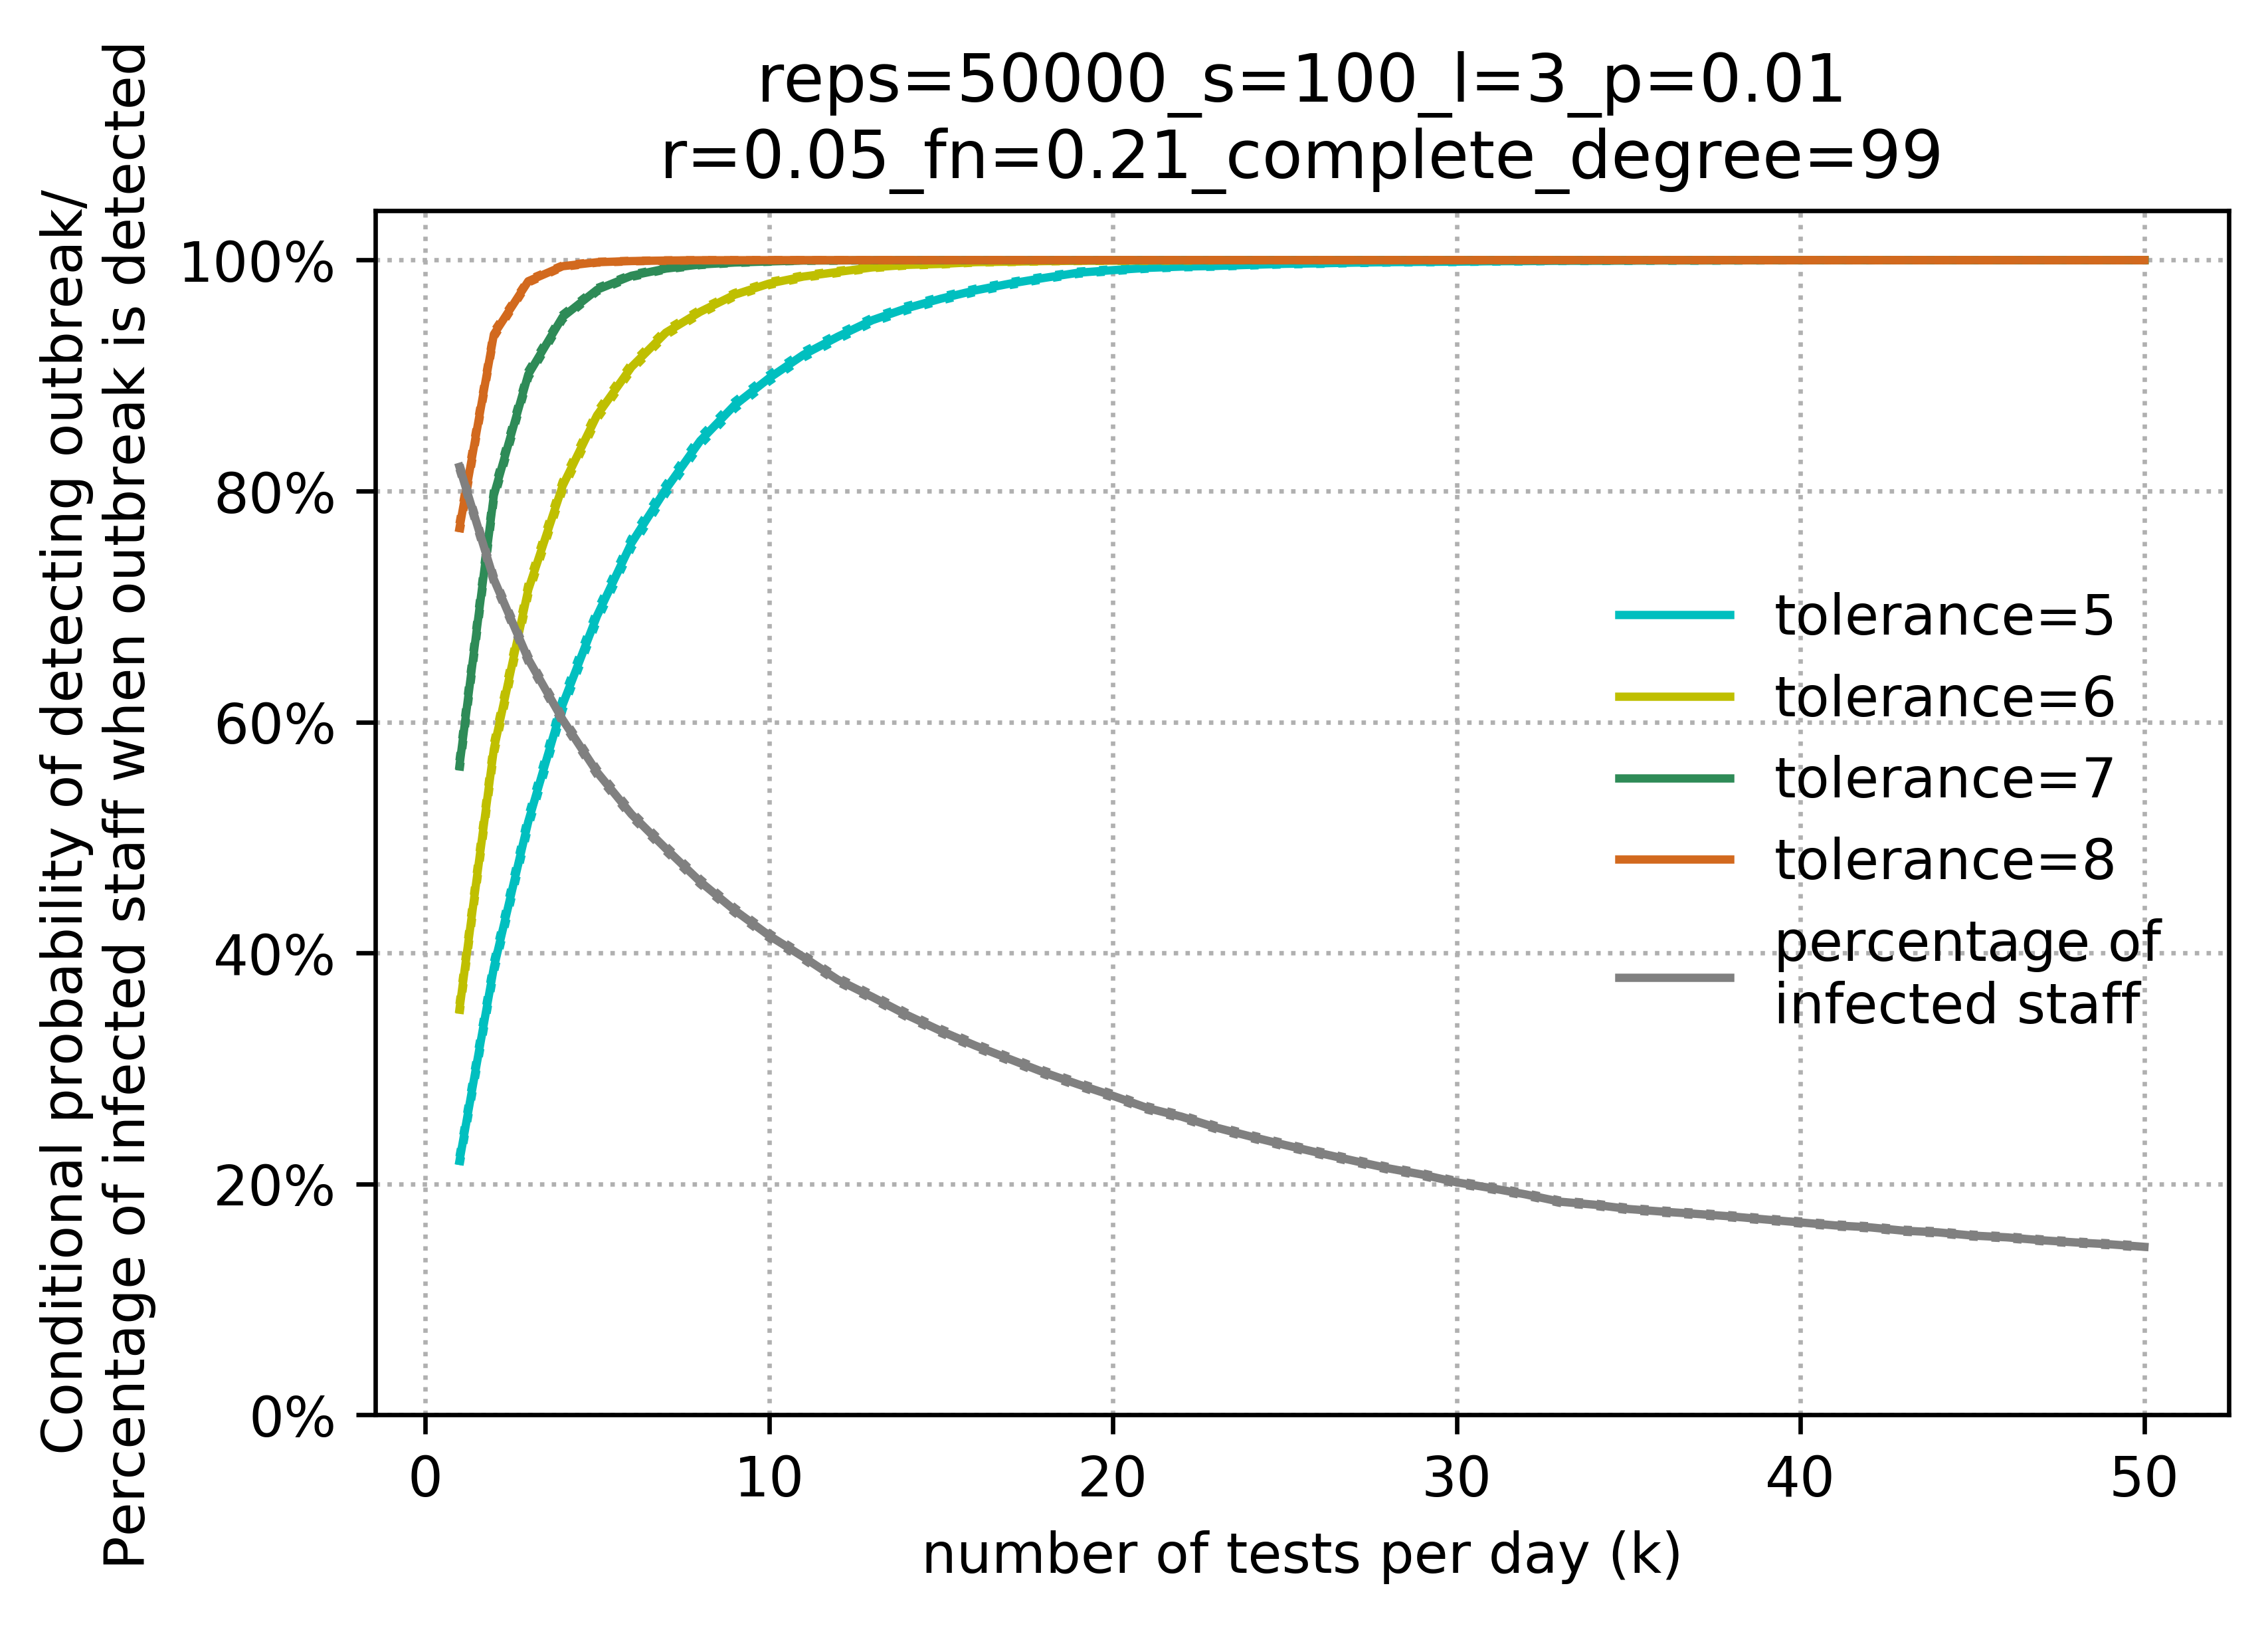

In [118]:
fig,ax=plt.subplots()
gtyp='complete'
for s in [100]:
    for p in [0.01]:
        for l in [3]:  
            for J in [1]:
                for I in [50000]:
                    x=[i for i in range(1,51)]
                    t_0=5
                    d=D[(J, I, s, p, r, fn, l, t_0, T)]
                    plt.plot(x, d['Prob_detected'].tolist(),'c-',label='tolerance={}'.format(t_0))
                    plt.plot(x, d['CI lower'].tolist(),'c:')
                    plt.plot(x, d['CI upper'].tolist(),'c:')
                    
                    
                    t_0=6
                    d=D[(J, I, s, p, r, fn, l, t_0, T)]
                    plt.plot(x, d['Prob_detected'].tolist(),'y-',label='tolerance={}'.format(t_0))
                    plt.plot(x, d['CI lower'].tolist(),'y:')
                    plt.plot(x, d['CI upper'].tolist(),'y:')
                    
                    t_0=7
                    d=D[(J, I, s, p, r, fn, l, t_0, T)]
                    plt.plot(x, d['Prob_detected'].tolist(),color='seagreen',linestyle='-',label='tolerance={}'.format(t_0))
                    plt.plot(x, d['CI lower'].tolist(),color='seagreen',linestyle=':')
                    plt.plot(x, d['CI upper'].tolist(),color='seagreen',linestyle=':')
                    
                    
                    t_0=8
                    d=D[(J, I, s, p, r, fn, l, t_0, T)]
                    plt.plot(x, d['Prob_detected'].tolist(),color='chocolate',linestyle='-',label='tolerance={}'.format(t_0))
                    plt.plot(x, d['CI lower'].tolist(),color='chocolate',linestyle=':')
                    plt.plot(x, d['CI upper'].tolist(),color='chocolate',linestyle=':')
d1=D1[(1, 50000, 100, 0.01, 0.05, 0.21, 3, 15, T)]
plt.plot(x, d1['portion_infected'].tolist(),color='gray',linestyle='-',label='percentage of \ninfected staff')
plt.plot(x, d1['portion_LB'].tolist(),color='gray',linestyle=':')
plt.plot(x, d1['portion_UB'].tolist(),color='gray',linestyle=':')                    
plt.legend(loc='best', frameon=False)
plt.title("reps={1}_s={2}_l={3}_p={5}\nr={6}_fn={7}_{8}_degree={9}".format(J,I, s,l, t_0, p, r, fn,gtyp,99))
plt.yticks([i*0.2 for i in range(6)])
vals = [0,0.2,0.4,0.6,0.8,1.0]
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
ax.grid(linestyle=':')
plt.xlabel('number of tests per day (k)')
plt.ylabel('Conditional probability of detecting outbreak/ \n Percentage of infected staff when outbreak is detected')
plt.show()

In [ ]:
D2[]

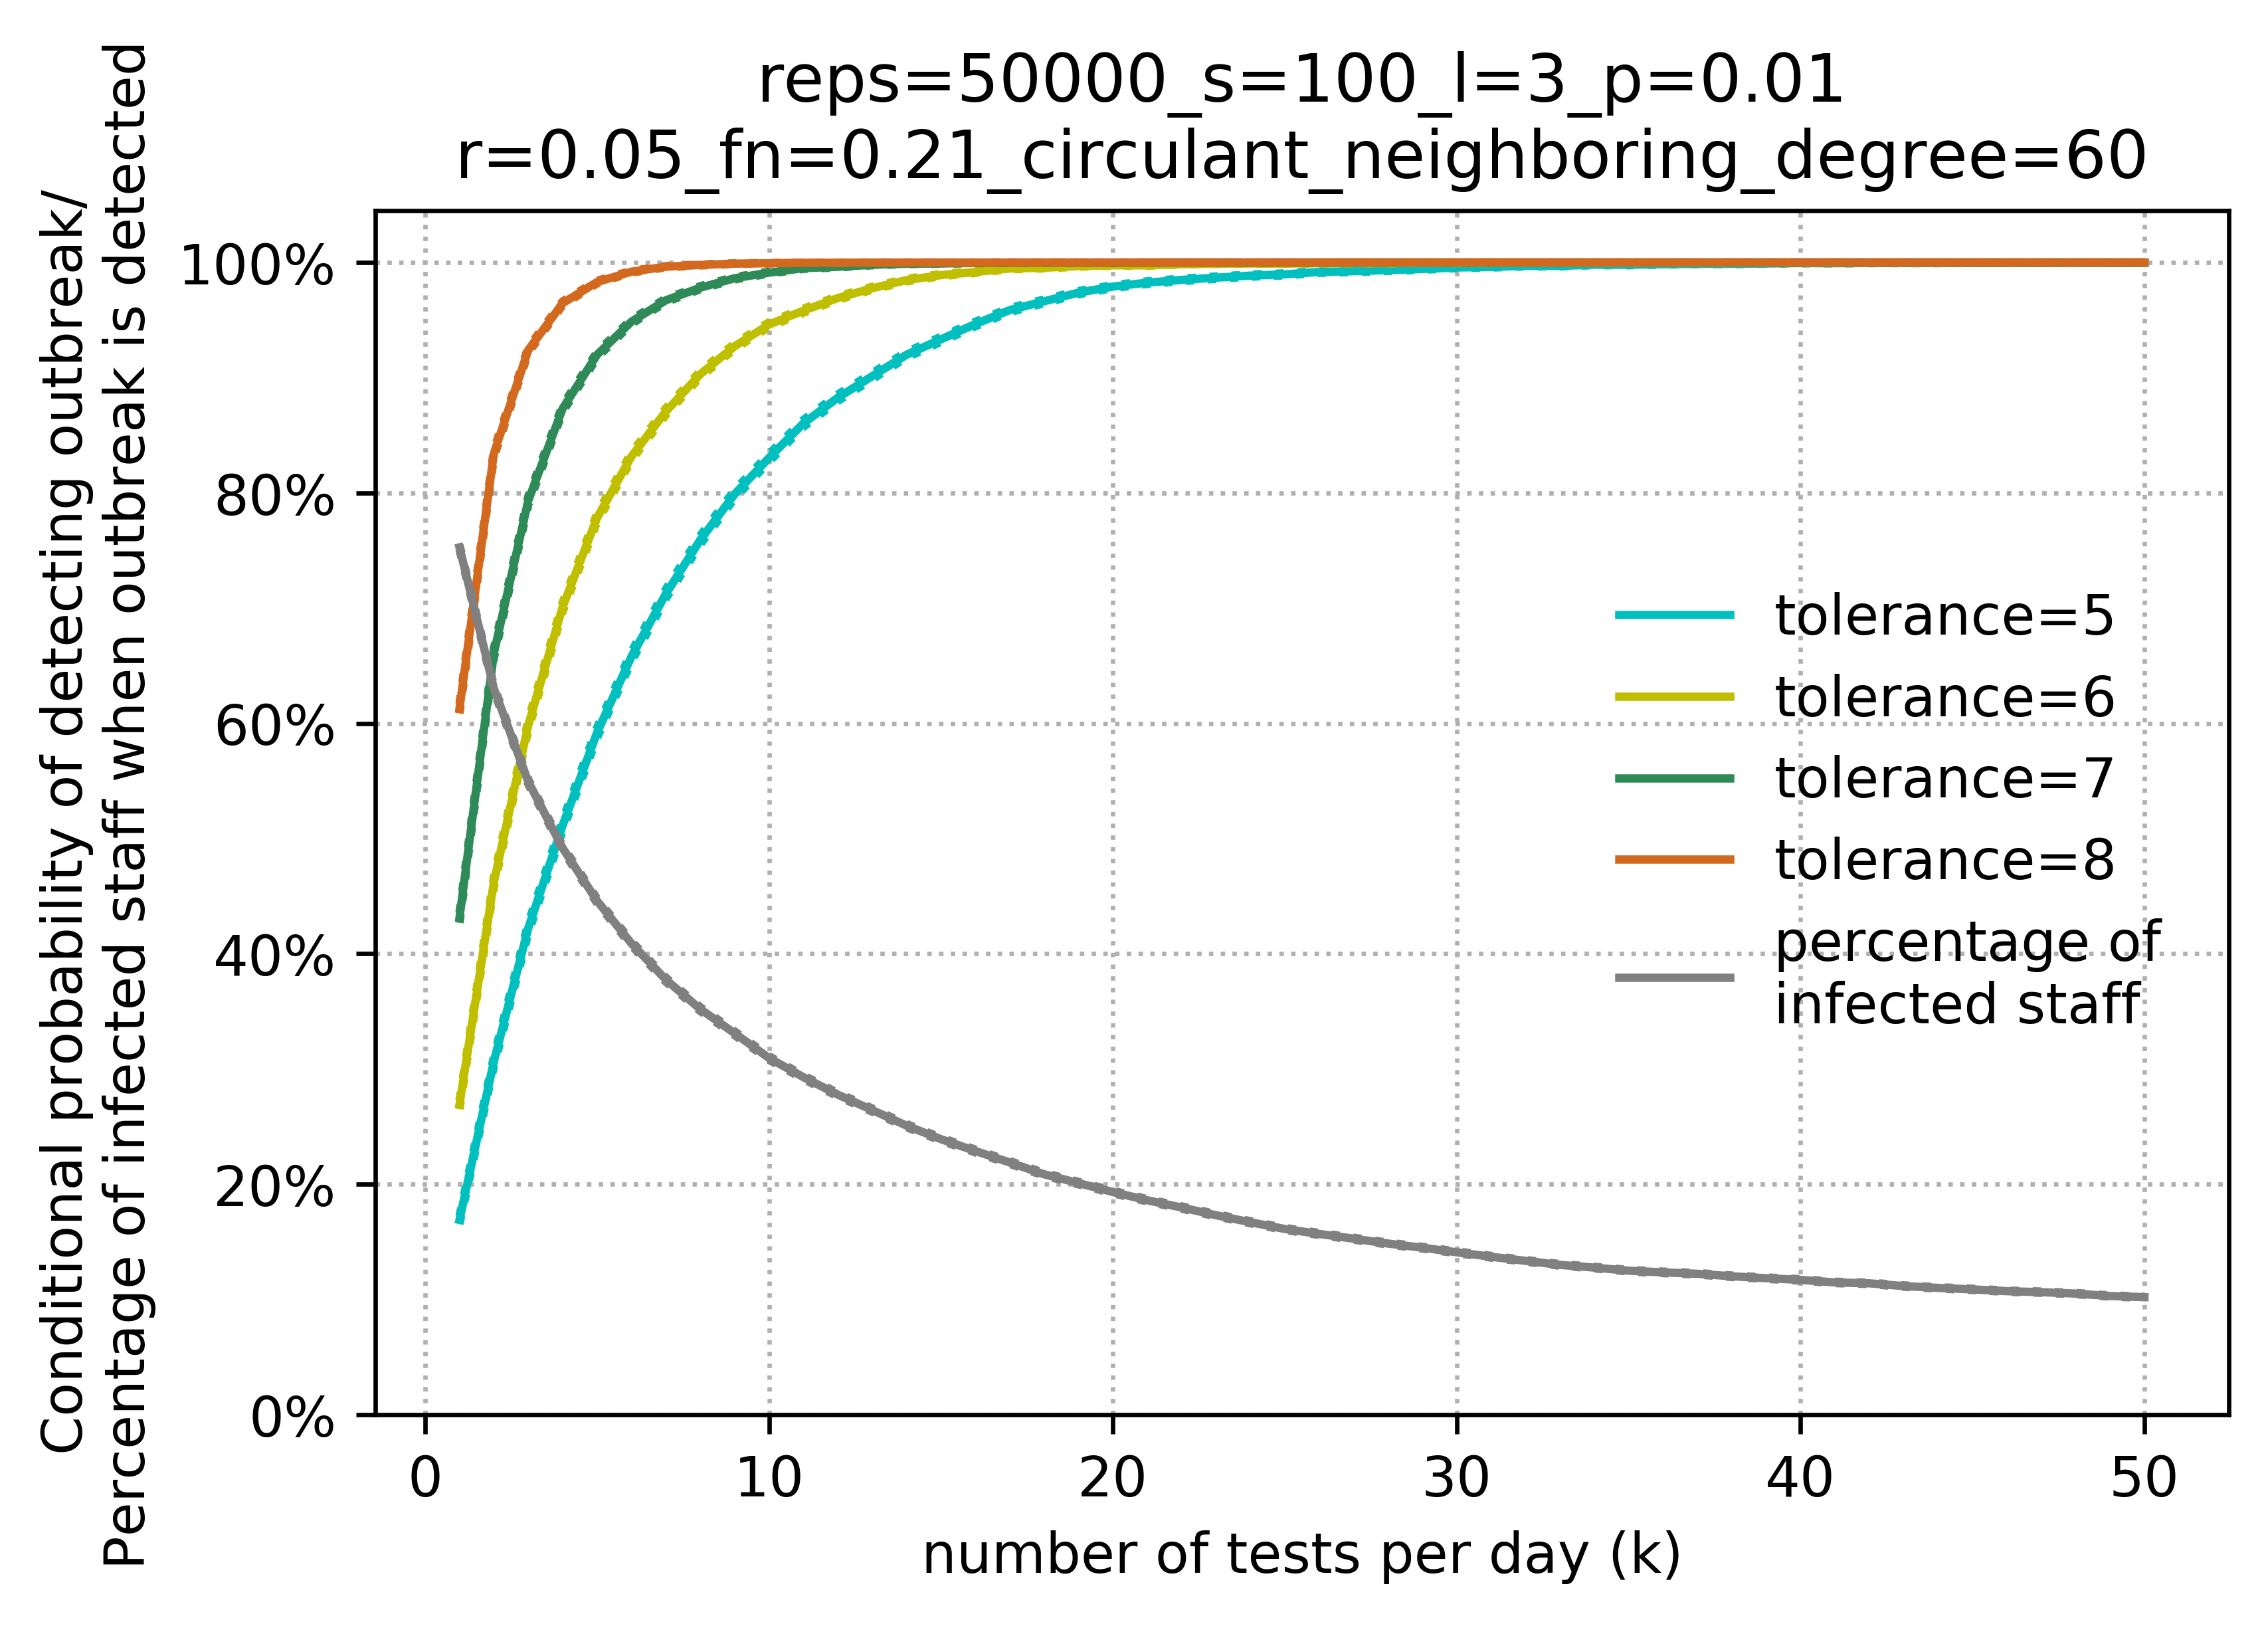

In [114]:
data=pd.ExcelFile('OUTPUT0620test.xlsx')
D={}
for s in [100]:
    for p in [0.01]:
        for l in [3]:  
            for J in [1]:
                for I in [50000]:
                    for t_0 in [5,6,7,8]:
                        D[(J, I, s, p, r, fn, l, t_0, T)]=pd.read_excel(data,'{0}_{1}_{2}_{3}_{4}_{5}_{6}'.format(J,I,s,60,p,l,t_0))
fig,ax=plt.subplots()
gtyp='circulant_neighboring'
for s in [100]:
    for p in [0.01]:
        for l in [3]:  
            for J in [1]:
                for I in [50000]:
                    x=[i for i in range(1,51)]
                    t_0=5
                    d=D[(J, I, s, p, r, fn, l, t_0, T)]
                    plt.plot(x, d['Prob_detected'].tolist(),'c-',label='tolerance={}'.format(t_0))
                    plt.plot(x, d['CI lower'].tolist(),'c:')
                    plt.plot(x, d['CI upper'].tolist(),'c:')
                    
                    t_0=6
                    d=D[(J, I, s, p, r, fn, l, t_0, T)]
                    plt.plot(x, d['Prob_detected'].tolist(),'y-',label='tolerance={}'.format(t_0))
                    plt.plot(x, d['CI lower'].tolist(),'y:')
                    plt.plot(x, d['CI upper'].tolist(),'y:')
                    
                    t_0=7
                    d=D[(J, I, s, p, r, fn, l, t_0, T)]
                    plt.plot(x, d['Prob_detected'].tolist(),color='seagreen',linestyle='-',label='tolerance={}'.format(t_0))
                    plt.plot(x, d['CI lower'].tolist(),color='seagreen',linestyle=':')
                    plt.plot(x, d['CI upper'].tolist(),color='seagreen',linestyle=':')
                   
                    plt.legend(loc='center right', frameon=False)
                    t_0=8
                    d=D[(J, I, s, p, r, fn, l, t_0, T)]
                    plt.plot(x, d['Prob_detected'].tolist(),color='chocolate',linestyle='-',label='tolerance={}'.format(t_0))
                    plt.plot(x, d['CI lower'].tolist(),color='chocolate',linestyle=':')
                    plt.plot(x, d['CI upper'].tolist(),color='chocolate',linestyle=':')
                    
                    plt.legend(loc='center right', frameon=False)
d2=D2[(1, 50000, 100, 0.01, 0.05, 0.21, 3, 15, T)]
plt.plot(x, d2['portion_infected'].tolist(),color='gray',linestyle='-',label='percentage of \ninfected staff')
plt.plot(x, d2['portion_LB'].tolist(),color='gray',linestyle=':')
plt.plot(x, d2['portion_UB'].tolist(),color='gray',linestyle=':') 
plt.legend(loc='best', frameon=False)
plt.title("reps={1}_s={2}_l={3}_p={5}\nr={6}_fn={7}_{8}_degree={9}".format(J,I, s,l, t_0, p, r, fn,gtyp,60))
plt.yticks([i*0.2 for i in range(6)])
vals = [0,0.2,0.4,0.6,0.8,1.0]
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
ax.grid(linestyle=':')
plt.xlabel('number of tests per day (k)')
plt.ylabel('Conditional probability of detecting outbreak/ \n Percentage of infected staff when outbreak is detected')
plt.show()

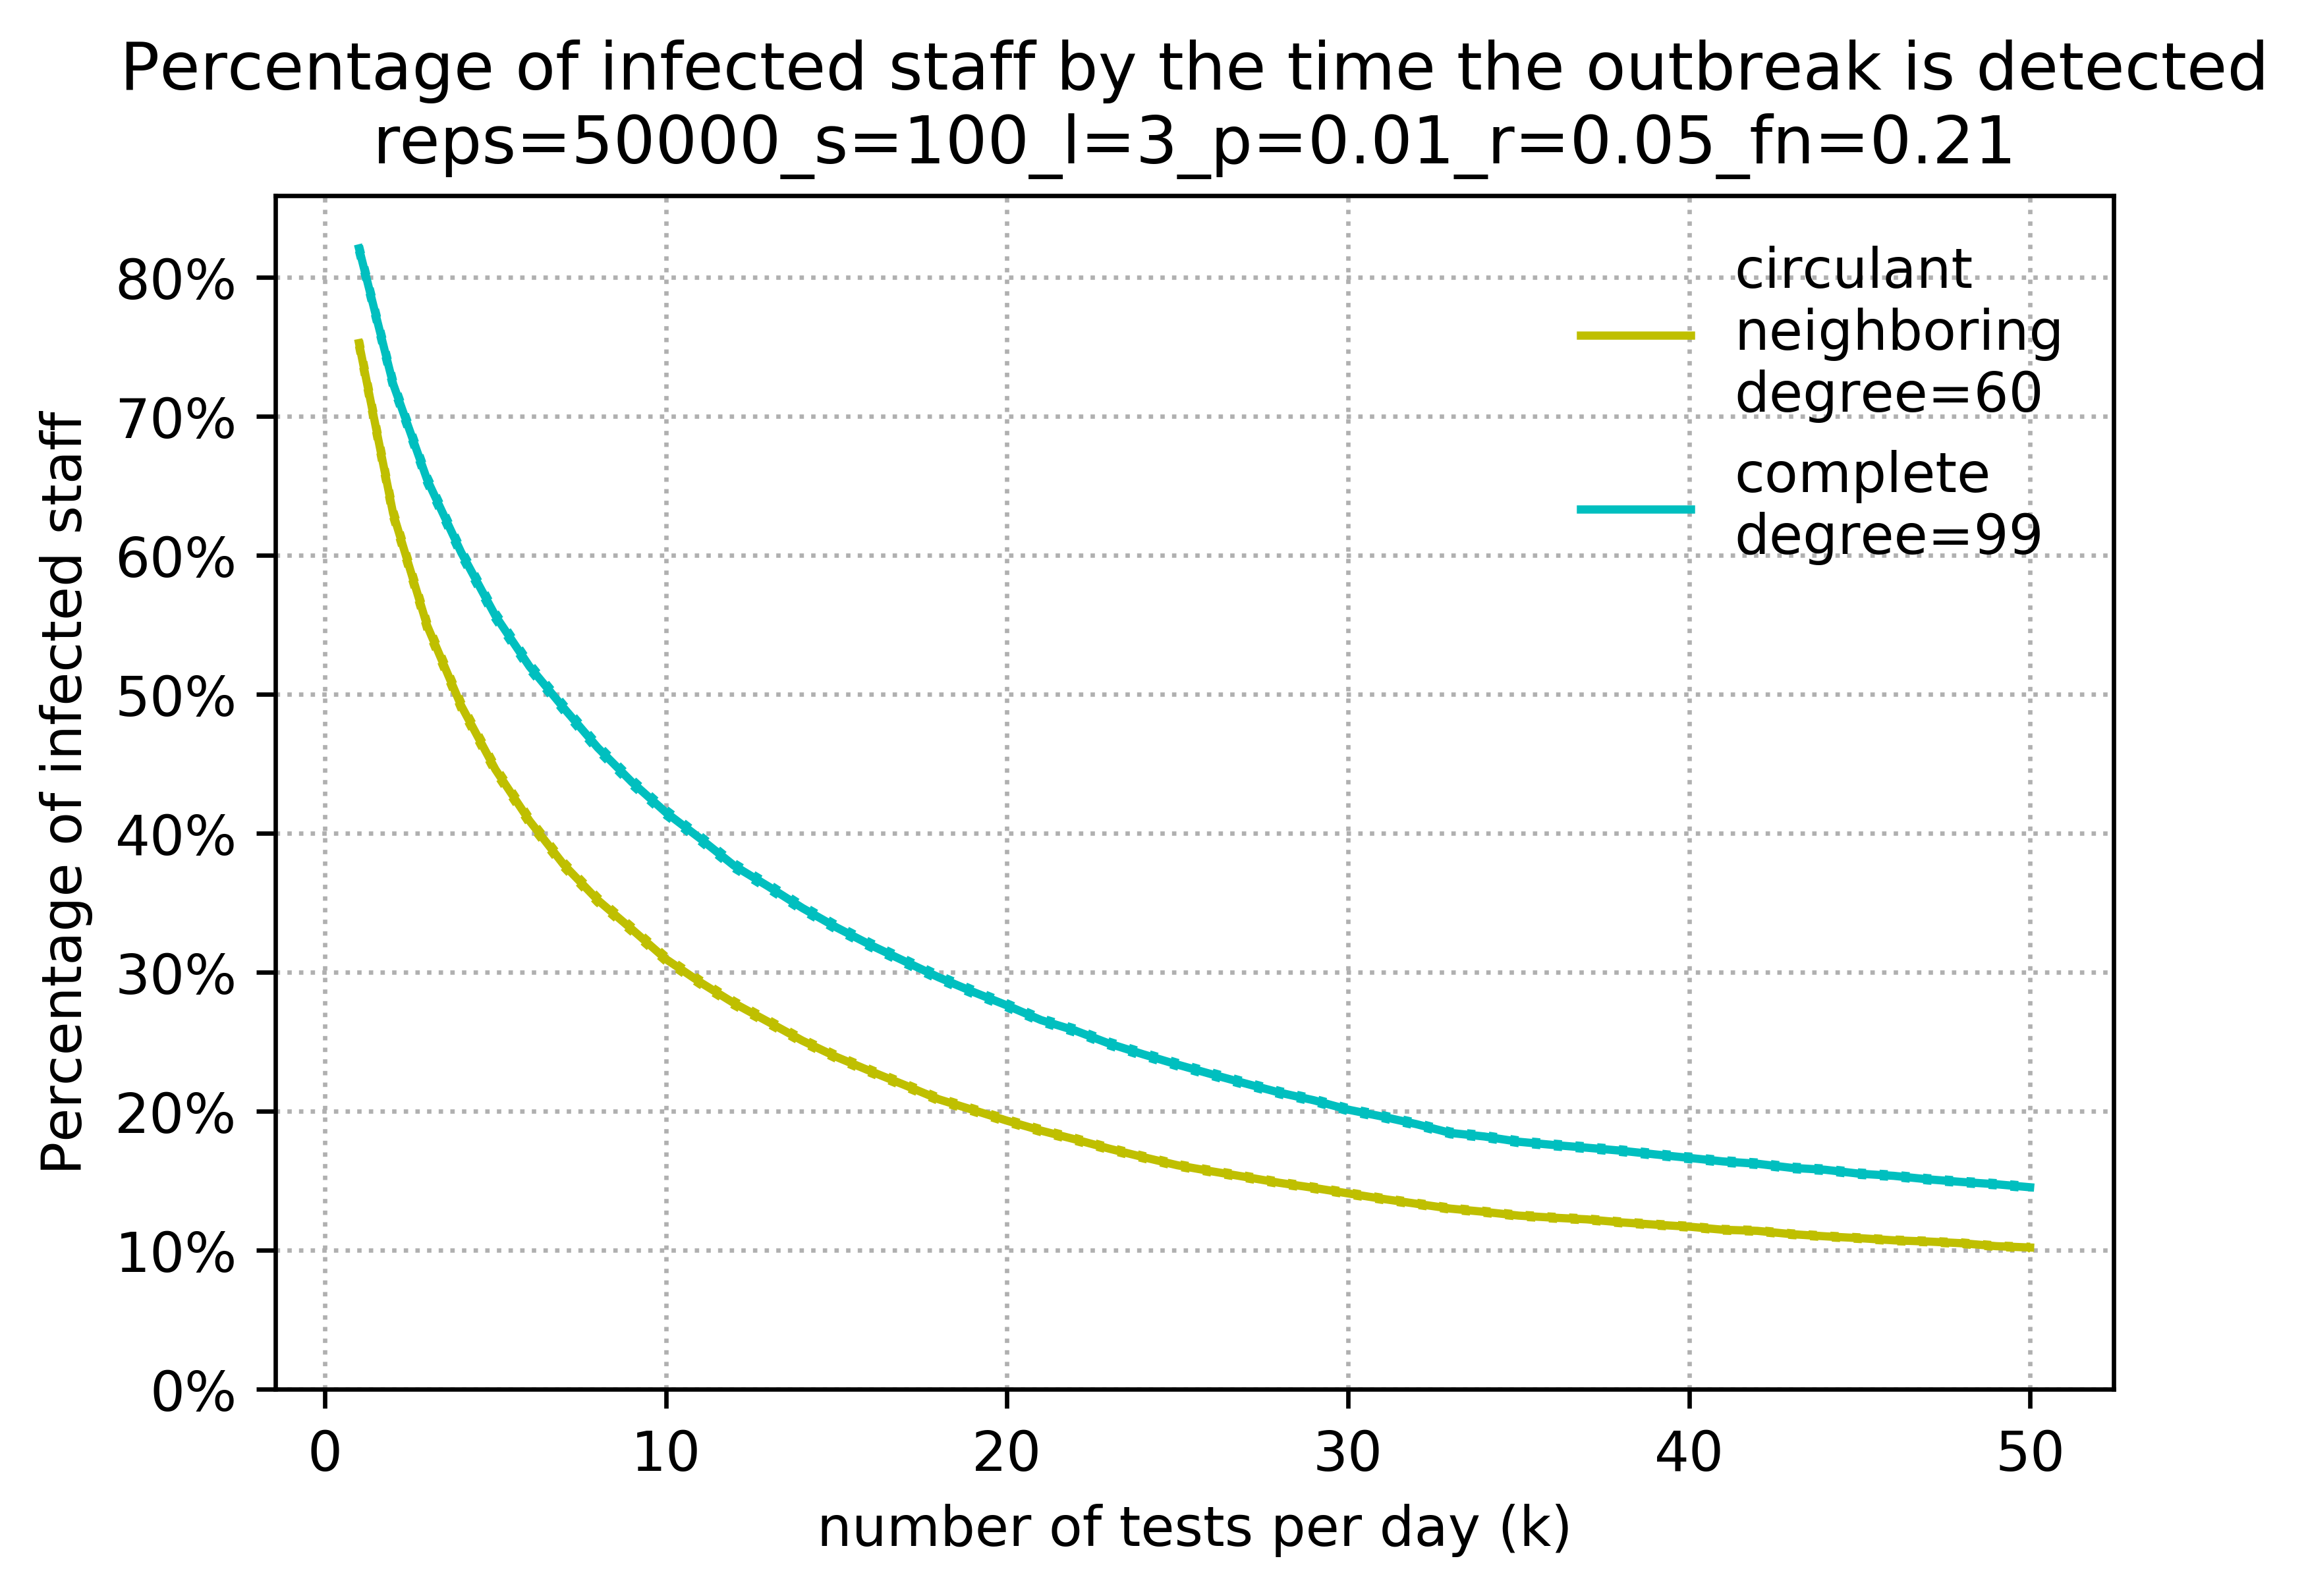

In [123]:
fig,ax=plt.subplots()
 


d2=D2[(1, 50000, 100, 0.01, 0.05, 0.21, 3, 15, T)]
plt.plot(x, d2['portion_infected'].tolist(),color='y',linestyle='-',label='circulant\nneighboring\ndegree=60')
plt.plot(x, d2['portion_LB'].tolist(),color='y',linestyle=':')
plt.plot(x, d2['portion_UB'].tolist(),color='y',linestyle=':')

d1=D1[(1, 50000, 100, 0.01, 0.05, 0.21, 3, 15, T)]
plt.plot(x, d1['portion_infected'].tolist(),color='c',linestyle='-',label='complete\ndegree=99')
plt.plot(x, d1['portion_LB'].tolist(),color='c',linestyle=':')
plt.plot(x, d1['portion_UB'].tolist(),color='c',linestyle=':') 
plt.legend(loc='best', frameon=False)
plt.title("Percentage of infected staff by the time the outbreak is detected\nreps={1}_s={2}_l={3}_p={5}_r={6}_fn={7}".format(J,I, s,l, t_0, p, r, fn,gtyp,60))
plt.yticks([i*0.1 for i in range(9)])
vals = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals]) 
ax.grid(linestyle=':')
plt.xlabel('number of tests per day (k)')
plt.ylabel('Percentage of infected staff')
plt.show()

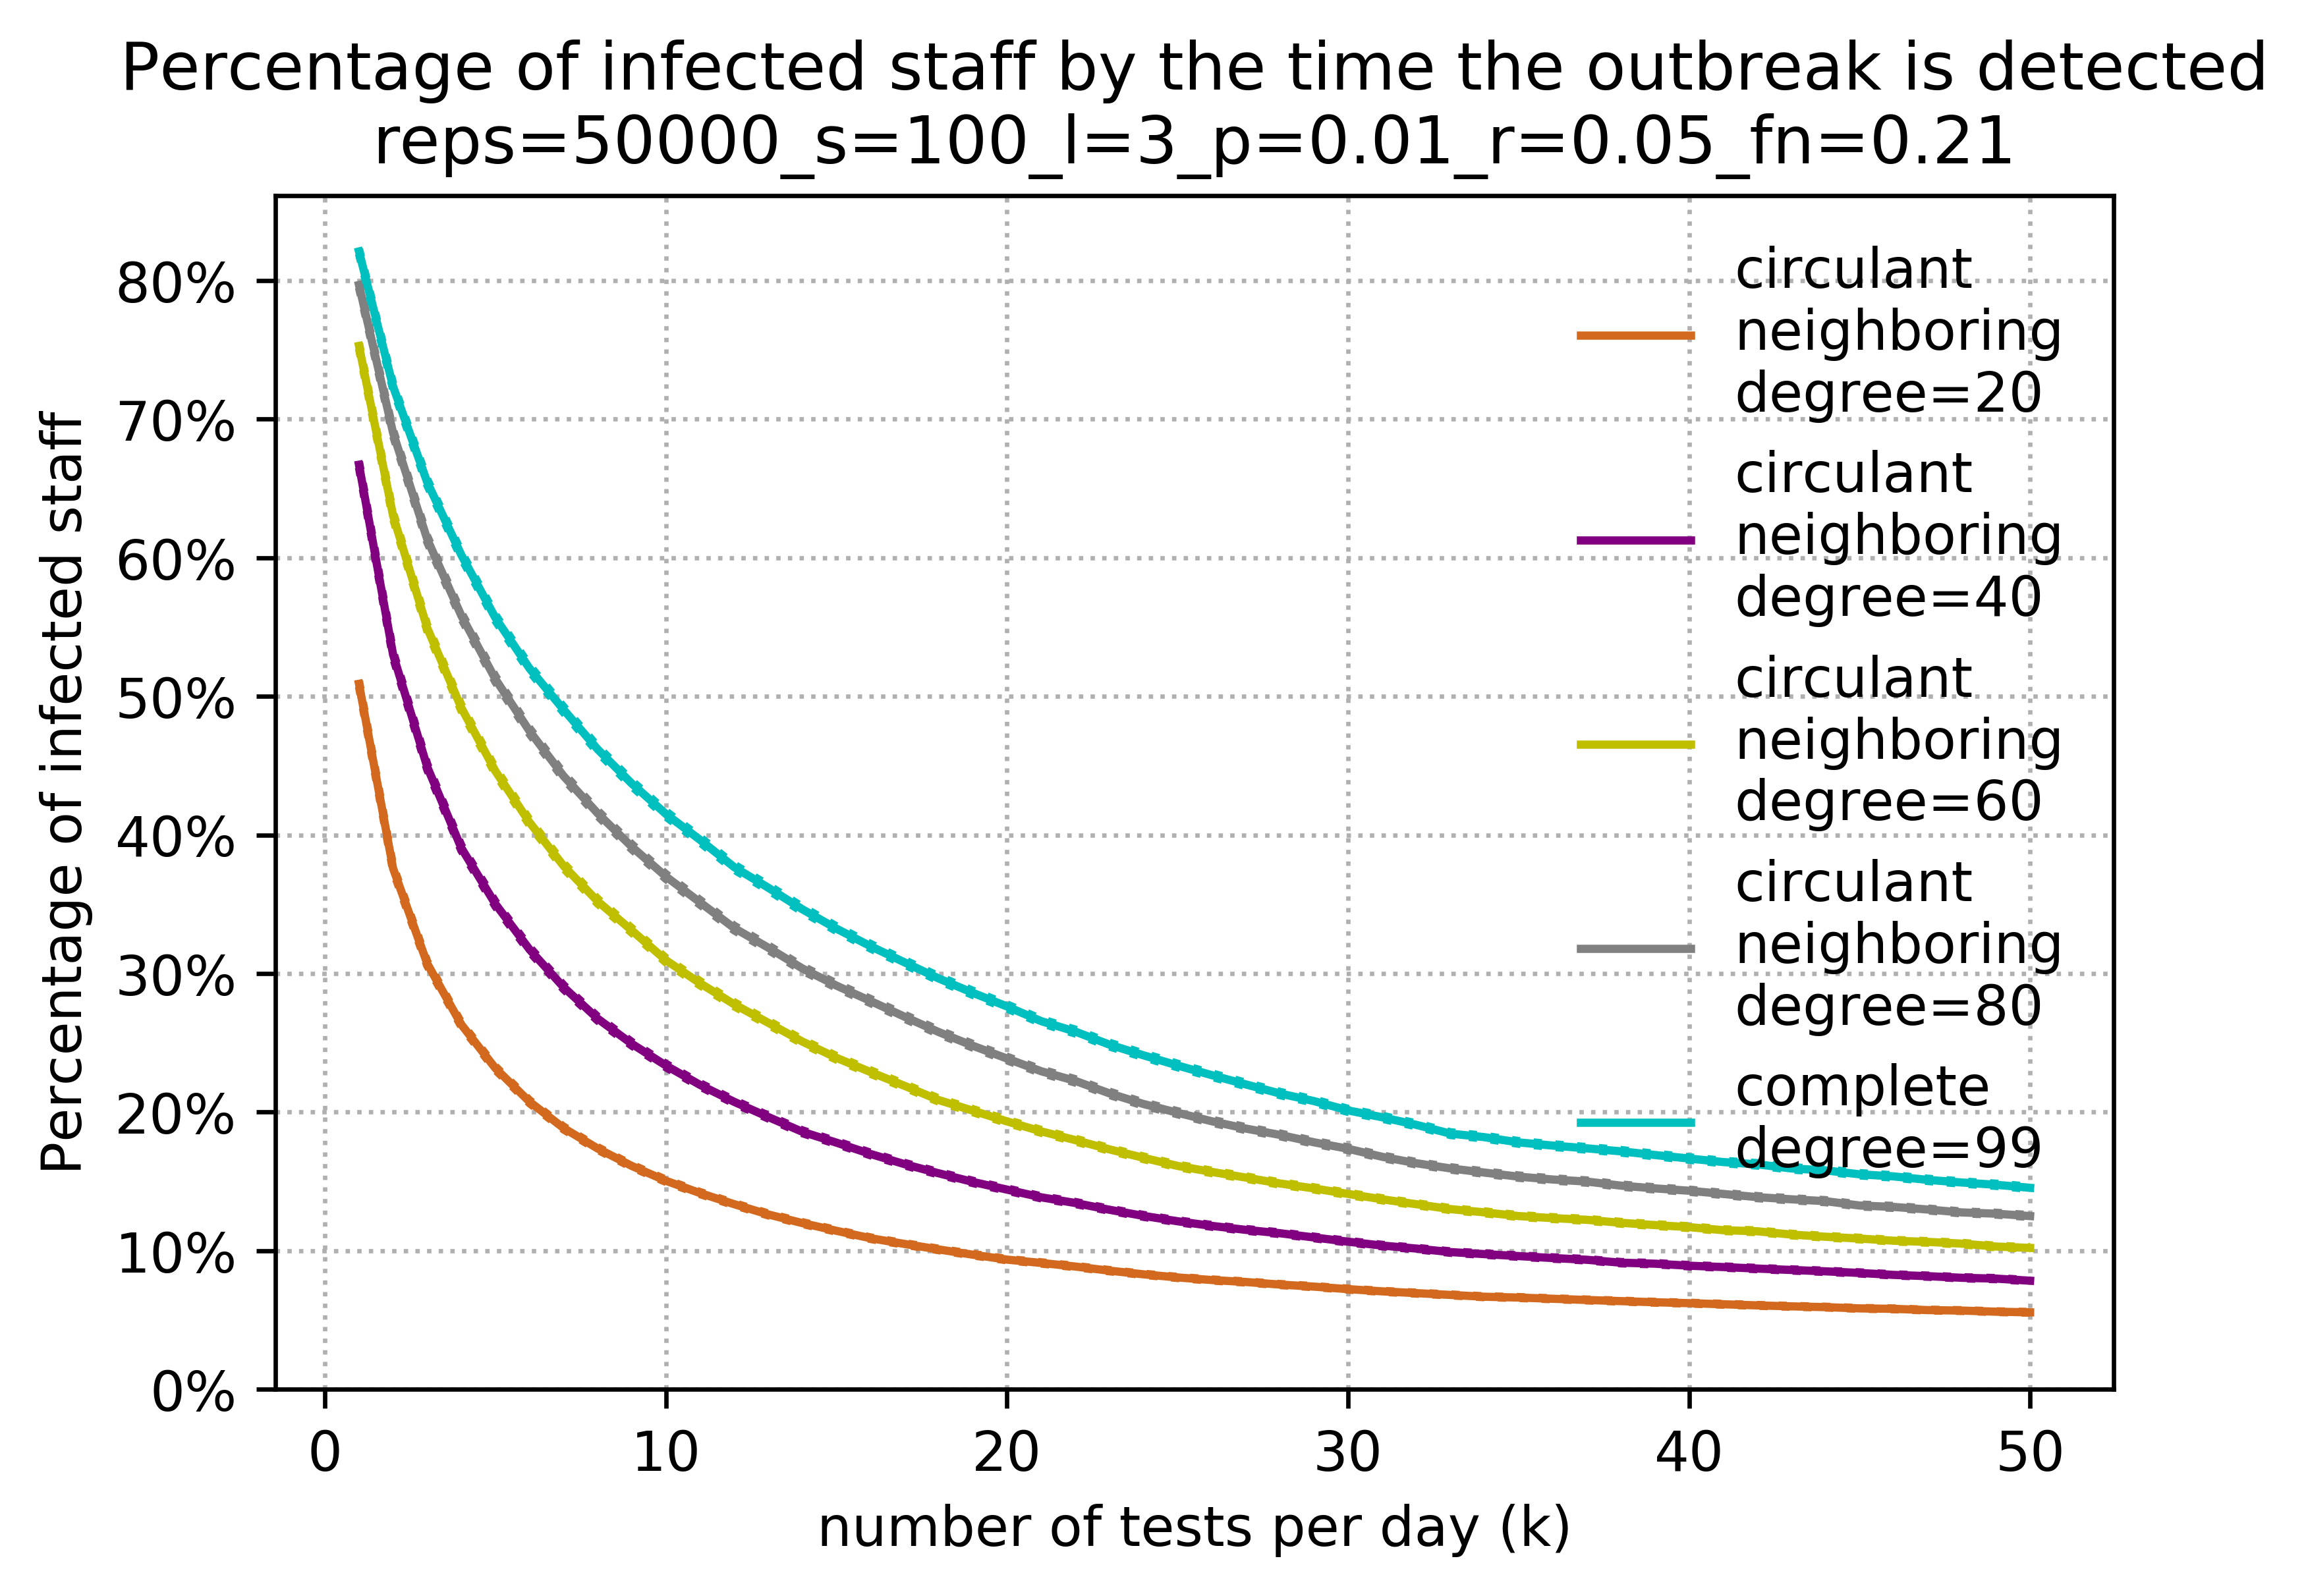

In [124]:
fig,ax=plt.subplots()
 

d20=D3[20]
plt.plot(x, d20['portion_infected'].tolist(),color='chocolate',linestyle='-',label='circulant\nneighboring\ndegree=20')
plt.plot(x, d20['portion_LB'].tolist(),color='chocolate',linestyle=':')
plt.plot(x, d20['portion_UB'].tolist(),color='chocolate',linestyle=':') 
plt.legend(loc='best', frameon=False)
d40=D3[40]
plt.plot(x, d40['portion_infected'].tolist(),color='purple',linestyle='-',label='circulant\nneighboring\ndegree=40')
plt.plot(x, d40['portion_LB'].tolist(),color='purple',linestyle=':')
plt.plot(x, d40['portion_UB'].tolist(),color='purple',linestyle=':') 
plt.legend(loc='best', frameon=False)
d2=D2[(1, 50000, 100, 0.01, 0.05, 0.21, 3, 15, T)]
plt.plot(x, d2['portion_infected'].tolist(),color='y',linestyle='-',label='circulant\nneighboring\ndegree=60')
plt.plot(x, d2['portion_LB'].tolist(),color='y',linestyle=':')
plt.plot(x, d2['portion_UB'].tolist(),color='y',linestyle=':')
d80=D3[80]
plt.plot(x, d80['portion_infected'].tolist(),color='gray',linestyle='-',label='circulant\nneighboring\ndegree=80')
plt.plot(x, d80['portion_LB'].tolist(),color='gray',linestyle=':')
plt.plot(x, d80['portion_UB'].tolist(),color='gray',linestyle=':') 
plt.legend(loc='best', frameon=False)
d1=D1[(1, 50000, 100, 0.01, 0.05, 0.21, 3, 15, T)]
plt.plot(x, d1['portion_infected'].tolist(),color='c',linestyle='-',label='complete\ndegree=99')
plt.plot(x, d1['portion_LB'].tolist(),color='c',linestyle=':')
plt.plot(x, d1['portion_UB'].tolist(),color='c',linestyle=':') 
plt.legend(loc='best', frameon=False)
plt.title("Percentage of infected staff by the time the outbreak is detected\nreps={1}_s={2}_l={3}_p={5}_r={6}_fn={7}".format(J,I, s,l, t_0, p, r, fn,gtyp,60))
plt.yticks([i*0.1 for i in range(9)])
vals = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals]) 
ax.grid(linestyle=':')
plt.xlabel('number of tests per day (k)')
plt.ylabel('Percentage of infected staff')
plt.show()

In [277]:
if __name__ == '__main__':
    DD={}
    writer1 = pd.ExcelWriter('cumulative_infected_0621.xlsx', engine = 'xlsxwriter')
    #writer1=pd.ExcelWriter('',engine = 'xlsxwriter')
    T=0.1
    fn=0.21
    r=0.05
    OUT={}
    data=[]
    for gtyp in ['circulant_neighbouring','circulant_crossing','random_d']:
        for d in [s,int(s*0.6//1),int(s*0.2//1)]:# d must be int format
            if d==s and gtyp!='circulant_neighbouring':
                continue
            for s in [100]:
                for p in [0.01]:
                    for t_0 in [20]:
                        for l in [3]:  
                            for J in [1]:
                                for I in [50000]:
                                    start=time.time()
                                    G=Generate_Nursing_Network(gtyp, s, d,p,r )
                                    OUT[d]=Simulation(J,I, s, G, p, r, l, t_0, T)
                                    for t in range(1,t_0+1):
                                        temp=[gtyp,d,t]
                                        DD[(d,t)]=[(len(OUT[d][3][(1,i)][t])-1) for i in range(1,I+1)]
                                        temp.append(statistics.mean(DD[(d,t)]))
                                        temp.append(statistics.stdev(DD[(d,t)]))
                                        temp.append(temp[3]-1.96*temp[4]/math.sqrt(I))
                                        temp.append(min(temp[3]+1.96*temp[4]/math.sqrt(I),100))
                                        data.append(temp)
                                    print('running time',time.time()-start)
    
    #--------------------------------------------------------------------------------------------------
    d2=pd.DataFrame(data)
    d2.columns=['graphtype','degree','time','exp','sd','lowerbound','upperbound']
    #print(d2)
    d2.to_excel(writer1)
    writer1.save()

running time 3274.914920091629
running time 3172.48122382164
running time 4011.610339164734
running time 3104.495428085327
running time 3548.415702819824
running time 3057.830897092819
running time 3341.0215289592743


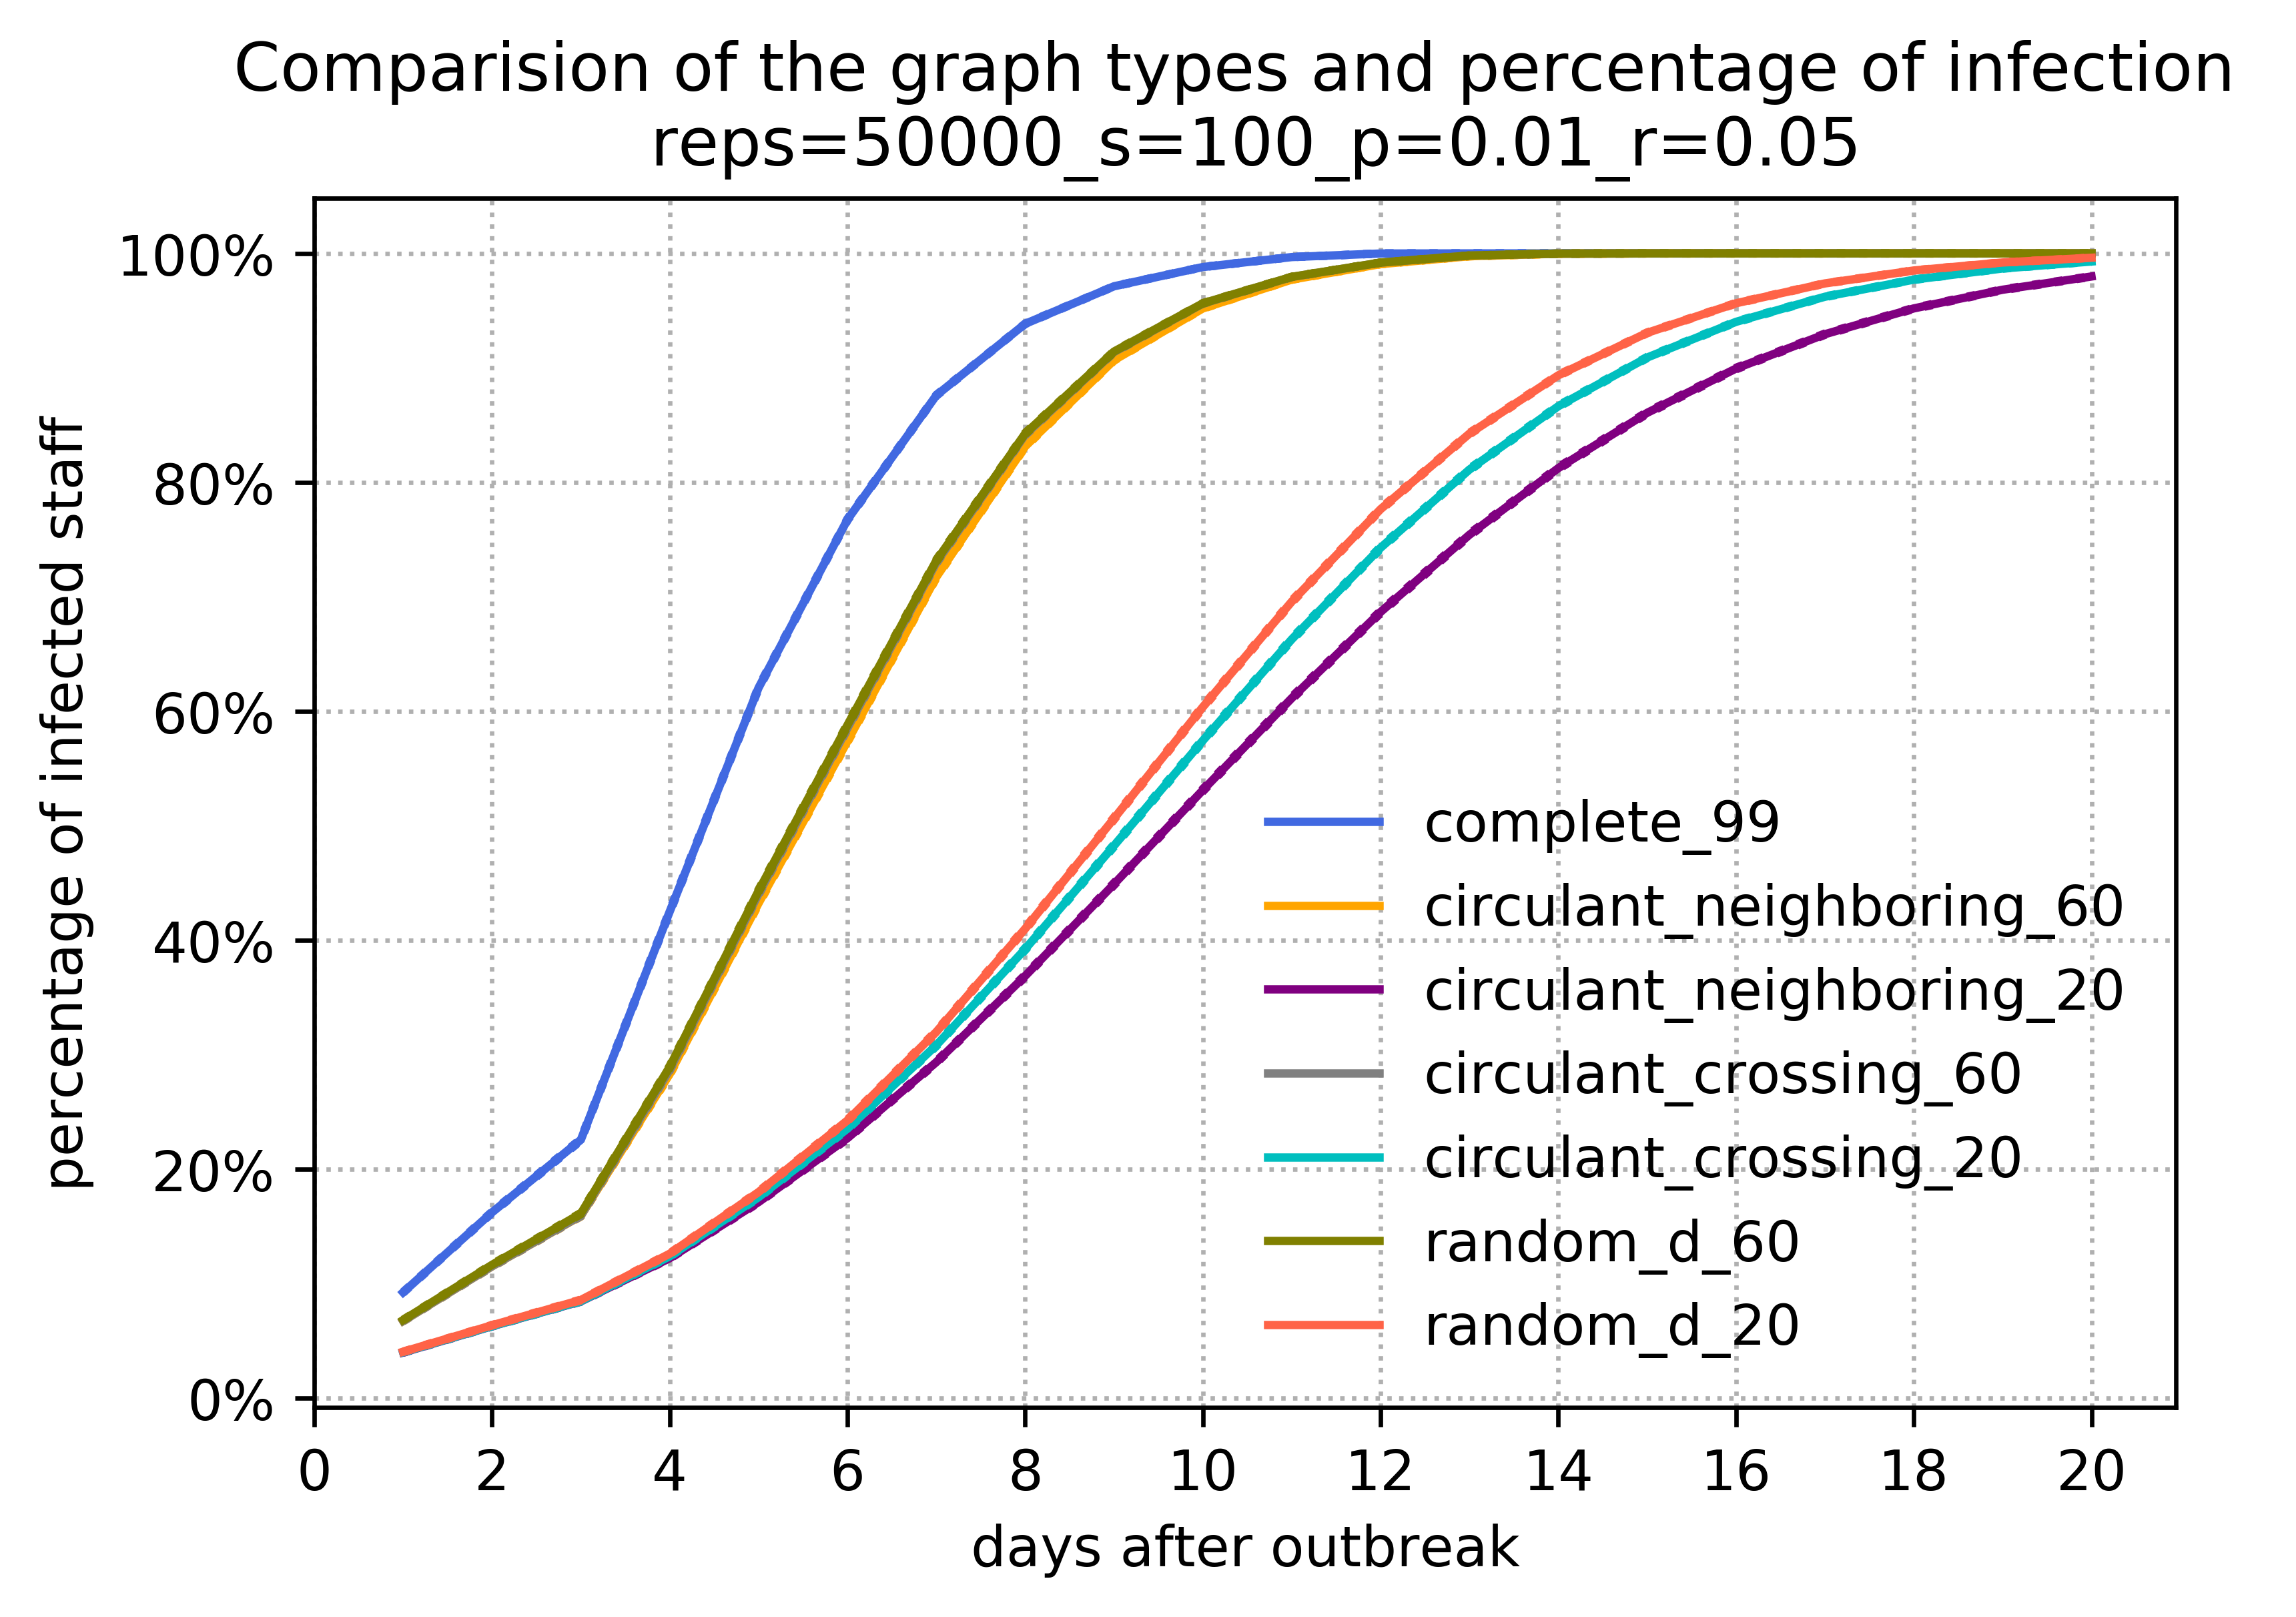

In [28]:
d2=pd.read_excel('cumulative_infected_0621.xlsx')
fig,ax=plt.subplots()
t=[i for i in range(1,21)]
colors=['royalblue','orange','purple','gray','c','olive','tomato']
position=[i*20+20 for i in range(7)]
for i in range(7):
    plt.plot(t,d2['exp'].iloc[(position[i]-20):position[i]].tolist(),color=colors[i],linestyle='-',label='{0}_{1}'.format(str(d2['graphtype'][position[i]-1]),str(d2['degree'][position[i]-1])))
    plt.plot(t,d2['lowerbound'].iloc[(position[i]-20):position[i]].tolist(),color=colors[i],linestyle=':')
    plt.plot(t,d2['upperbound'].iloc[(position[i]-20):position[i]].tolist(),color=colors[i],linestyle=':')
    
plt.legend(loc='lower right', frameon=False)
plt.title("Comparision of the graph types and percentage of infection \n reps=50000_s=100_p=0.01_r=0.05")
plt.xlabel('days after outbreak')
plt.ylabel('percentage of infected staff')
plt.xticks([i*2 for i in range(11)])
vals = [0,0,0.2,0.4,0.6,0.8,1.0]
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
ax.grid(linestyle=':')
plt.show()